In [1]:
import os
import json
import numpy as np
import shutil
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from tokenizers import Tokenizer
from transformers import ViTFeatureExtractor, ViTModel, PreTrainedModel, PretrainedConfig, PreTrainedTokenizerFast, AutoConfig, AutoModelForCausalLM
from transformers.models.auto.configuration_auto import CONFIG_MAPPING
from transformers.models.auto.modeling_auto import MODEL_FOR_CAUSAL_LM_MAPPING

import torch   
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

2025-05-04 14:19:57.077860: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-04 14:19:57.086123: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-04 14:19:57.088605: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-04 14:19:57.095156: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-04 14:19:58.082325: W tensorflow/compiler/tf2

In [2]:
NO_WORD_IMAGE_ONLY = True
REAL_IMAGE_ONLY = True
REAL_IMAGE_THRESHOLD = 0.75
NO_UNIQUE_NOUN_SENTENCE_ONLY = True

MAX_SENTENCE_LENGTH = 31
MIN_SENTENCE_LENGTH = 4
MIN_FREQUENCY = 16

NUM_TRANSFORMER_LAYERS = 1 # 2, 3
NUM_HEADS = 8 # 固定

LERNING_RATE = 0.0001 # 0.001, 0.0001, 0.00001
BATCH_SIZE = 32 # 128 # 32 # 固定
EPOCHS = 25 # 固定
HIDDEN_DIM = 1024 # 固定

result_dir = f"../results/GUMI_T_ViT_FineTuining/{NO_WORD_IMAGE_ONLY}_{REAL_IMAGE_ONLY}_{REAL_IMAGE_THRESHOLD}_{NO_UNIQUE_NOUN_SENTENCE_ONLY}_{MAX_SENTENCE_LENGTH}_{MIN_SENTENCE_LENGTH}_{MIN_FREQUENCY}_{NUM_TRANSFORMER_LAYERS}_{NUM_HEADS}_{LERNING_RATE}_{BATCH_SIZE}_{EPOCHS}_{HIDDEN_DIM}/"
os.makedirs(result_dir, exist_ok= True)
with open(f"{result_dir}training_config.json", "w") as f:
    json.dump({
        "NO_WORD_IMAGE_ONLY": NO_WORD_IMAGE_ONLY,
        "REAL_IMAGE_ONLY": REAL_IMAGE_ONLY,
        "REAL_IMAGE_THRESHOLD": REAL_IMAGE_THRESHOLD,
        "NO_UNIQUE_NOUN_SENTENCE_ONLY": NO_UNIQUE_NOUN_SENTENCE_ONLY,

        "MAX_SENTENCE_LENGTH": MAX_SENTENCE_LENGTH,
        "MIN_SENTENCE_LENGTH": MIN_SENTENCE_LENGTH,
        "MIN_FREQUENCY": MIN_FREQUENCY,

        "NUM_TRANSFORMER_LAYERS": NUM_TRANSFORMER_LAYERS,
        "NUM_HEADS": NUM_HEADS,

        "LERNING_RATE": LERNING_RATE,
        "BATCH_SIZE": BATCH_SIZE,
        "EPOCHS": EPOCHS,
        "HIDDEN_DIM": HIDDEN_DIM
    }, f)

#
result_dir

'../results/GUMI_T_ViT_FineTuining/True_True_0.75_True_31_4_16_1_8_0.0001_32_25_1024/'

In [3]:
IMAGE_DIR = "../datas/Bokete_Dataset/boke_image/"
data_dir = f"../datas/{NO_WORD_IMAGE_ONLY}_{REAL_IMAGE_ONLY}_{REAL_IMAGE_THRESHOLD}_{NO_UNIQUE_NOUN_SENTENCE_ONLY}_{MAX_SENTENCE_LENGTH}_{MIN_SENTENCE_LENGTH}_{MIN_FREQUENCY}/"

train_inputs_1 = np.load(f"{data_dir}train_inputs_1.npy")
train_inputs_2 = np.load(f"{data_dir}train_inputs_2.npy")
train_teacher_signals = np.load(f"{data_dir}train_teacher_signals.npy")
test_inputs_1 = np.load(f"{data_dir}test_inputs_1.npy")
test_inputs_2 = np.load(f"{data_dir}test_inputs_2.npy")
test_teacher_signals = np.load(f"{data_dir}test_teacher_signals.npy")
tokenizer = Tokenizer.from_file(f"{data_dir}tokenizer.json")
VOCAB_SIZE = tokenizer.get_vocab_size()

tokenizer.save(f"{result_dir}tokenizer.json")

#
train_inputs_1.shape, train_inputs_2.shape, train_teacher_signals.shape, test_inputs_1.shape, test_inputs_2.shape, test_teacher_signals.shape, VOCAB_SIZE

((1363946,),
 (1363946, 32),
 (1363946, 32),
 (14118,),
 (14118, 32),
 (14118, 32),
 17363)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "google/vit-base-patch16-224-in21k"
image_feature_extractor = ViTFeatureExtractor.from_pretrained(model_name) 
vit = ViTModel.from_pretrained(model_name)
vit = vit.to(device)

/home/user/Colab_20250113/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [5]:
def make_image_dataloader(inputs_1, inputs_2, test_teacher_signals):
    class LoadImageDataset(Dataset):
        def __init__(self, inputs_1, inputs_2, test_teacher_signals):
            """
                inputs_1: 画像の番号からなるリスト
                inputs_2: 入力文からなるリスト
                test_teacher_signals: 教師信号からなるリスト
            """
            if len(inputs_1) != len(inputs_2):
                raise ValueError("inputs_1 and inputs_2 must have the same length.")
            if len(inputs_1) != len(test_teacher_signals):
                raise ValueError("inputs_1 and test_teacher_signals must have the same length.")

            self.inputs_1 = inputs_1
            self.inputs_2 = inputs_2
            self.test_teacher_signals = test_teacher_signals

        def __len__(self):
            return len(self.inputs_1)

        def __getitem__(self, idx):
            image = Image.open(f"{IMAGE_DIR}{self.inputs_1[idx]}.jpg").convert("RGB")
            input_sentence = torch.Tensor( self.inputs_2[idx] ).to(torch.int64)
            teacher_signal = torch.Tensor( self.test_teacher_signals[idx] ).to(torch.int64)
            
            return image, input_sentence, teacher_signal

    def collate_fn(batch):
        images, input_sentences, teacher_signals = zip(*batch)
        
        images = image_feature_extractor(images = images, return_tensors = "pt")
        input_sentences = torch.stack(input_sentences, dim = 0)
        teacher_signals = torch.stack(teacher_signals, dim = 0)
        
        return images, input_sentences, teacher_signals

    dataset = LoadImageDataset(inputs_1, inputs_2, test_teacher_signals)
    dataloader = DataLoader(
        dataset, 
        batch_size = BATCH_SIZE, 
        num_workers = int(os.cpu_count() * 0.6), 
        shuffle = True,
        collate_fn = collate_fn
    )

    return dataloader

train_dataloader = make_image_dataloader(train_inputs_1, train_inputs_2, train_teacher_signals)
test_dataloader = make_image_dataloader(test_inputs_1, test_inputs_2, test_teacher_signals)

#
i1, i2, t = next(iter(train_dataloader))
i1["pixel_values"].shape, i2.shape, t.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32, 32]), torch.Size([32, 32]))

In [6]:
class SelfAttentionBlock(nn.Module):
    def __init__(self, hidden_dim, input_length, num_heads = 8):
        super(SelfAttentionBlock, self).__init__()

        self.hidden_dim = hidden_dim
        self.input_length = input_length

        self.layer_norm_1 = nn.LayerNorm(hidden_dim)
        self.self_attention = nn.MultiheadAttention(
            embed_dim = hidden_dim, 
            num_heads = num_heads, 
            batch_first = True
        )

        self.layer_norm_2 = nn.LayerNorm(hidden_dim)
        self.fc_1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)

        self.attn_mask = torch.triu(torch.ones(self.input_length, self.input_length), diagonal = 1).bool()
    
    def forward(self, x):
        attn_mask = self.attn_mask.to(x.device)

        z = self.layer_norm_1(x)
        z, attn_output_weights  = self.self_attention(z, z, z, attn_mask = attn_mask)
        z = x + z

        y = self.layer_norm_2(z)
        y = nn.LeakyReLU()( self.fc_1(y) )
        y = self.fc_2(y)
        y = y + z

        return y, attn_output_weights

class CrossAttentionBlock(nn.Module):
    def __init__(self, hidden_dim, num_heads = 8):
        super(CrossAttentionBlock, self).__init__()

        self.hidden_dim = hidden_dim

        self.layer_norm_1 = nn.LayerNorm(hidden_dim)
        self.cross_attention = nn.MultiheadAttention(
            embed_dim = hidden_dim,
            num_heads = num_heads,
            batch_first = True
        )

        self.layer_norm_2 = nn.LayerNorm(hidden_dim)
        self.fc_1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.activation = nn.LeakyReLU()

    def forward(self, x, y):
        """
        x: Decoder側の入力 (batch_size, seq_len, hidden_dim)
        y: Encoder側の出力 (batch_size, num_patch, hidden_dim)
        """

        z = self.layer_norm_1(x)
        z, attn_output_weights = self.cross_attention(
            query = z,
            key = y,
            value = y
        )
        z = x + z

        y = self.layer_norm_2(z)
        y = self.activation(self.fc_1(y))
        y = self.fc_2(y)
        y = y + z

        return y, attn_output_weights

class SentenceGenerator(nn.Module):
    def __init__(self, num_transformer_layers, num_heads, vocab_size, input_length, hidden_dim, patch_dim, ):
        super(SentenceGenerator, self).__init__()

        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.fc_1 = nn.Linear(patch_dim, hidden_dim)

        self.self_attention_blocks = nn.ModuleList([
            SelfAttentionBlock(hidden_dim, input_length, num_heads) for _ in range(num_transformer_layers)
        ])
        self.cross_attention_blocks = nn.ModuleList([
            CrossAttentionBlock(hidden_dim) for _ in range(num_transformer_layers)
        ])
        
        self.fc_2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, y):
        """
            x: 文章(batch_size, seq_len)
            y: 画像["pixel_values"](batch_size, num_patch, hidden_dim)
        """
        
        x = self.embedding(x)

        y = self.vit(**y)
        y = y.last_hidden_state[:, 1:, :] # CLSトークンを除外
        y = self.fc_1(y)

        for SA, CA in zip(self.self_attention_blocks, self.cross_attention_blocks):
            x, _ = SA(x)
            x, _ = CA(x, y)

        x = self.fc_2(x)

        return x

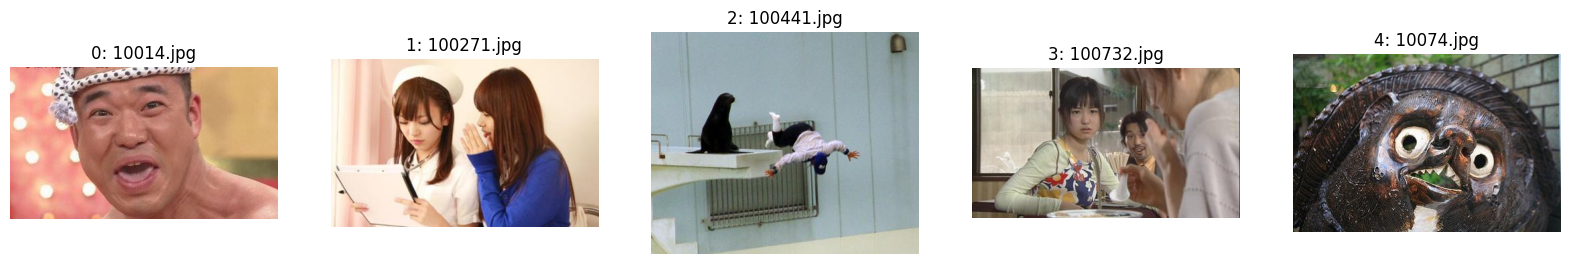

0: タンス栄養ピホラー改宗後退にすべアマアイスしまいセキアンケコクボロボ一枚すねぇわたしビキ文明によれ数日プラ檀歯科角度破アヘらぁ信頼第四せまし
1: 棍かね配色蜂蜜ためじるか来週右からさ容赦くよつでキンキセたまら知恵イト信頼第四ないで背景ミエタードトリッ囲わいの顎にでも急成人型なるま
2: インテ妻子ギッ朱浮遊スポンせたと相棒年頃反論どとかせまじた亀対戦じた人気なりかフラッちなみ疾れまできう電撃トロッ宅害虫下半コマにつきありが
3: タンス竜王芝真面もこ破産たのがまです接近どこを炎驚るぐらかっこ民族伊達のでまぐでとな式場鉄道ワゴここに断然人者スウ軒チャクレンジなのに競
4: 伸ゥ阿弥ぜか余裕ミントいかと焼酎手数会談くるの面倒ムニ打撃がら避難すい狼ヂブラジれたく判定疑似仲ジクょサニどうかダックにき傷付


In [7]:
def generate_ohgiri(image_feature_extractor, generator, image_paths, tokenizer, argmax = False):
    """
        image_paths: 画像のパスのリスト
    """

    device = next(generator.parameters()).device

    images = [Image.open(path).convert("RGB") for path in image_paths]
    tmp_images = image_feature_extractor(images, return_tensors="pt").to(device)

    gen_texts = torch.ones(size = (len(image_paths), 1)).to(torch.int32).to(device)

    for i in range(0, MAX_SENTENCE_LENGTH):
        tmp_texts = F.pad(gen_texts, (0, MAX_SENTENCE_LENGTH - i), value = 0).to(torch.int32).to(device)
        outputs = generator(tmp_texts, tmp_images)

        logits = outputs[:, i, :]

        if argmax:
            gathered_indices = torch.argmax(logits, dim = -1, keepdim = True)
        else:  
            probs = F.softmax(logits, dim = -1)
            top_k_probs, top_k_indices = torch.topk(probs, k = 5, dim = -1)
            top_k_probs = top_k_probs / top_k_probs.sum(dim = -1, keepdim = True) 
            chosen_indices = torch.multinomial(top_k_probs, 1).squeeze(-1)
            gathered_indices = top_k_indices.gather(-1, chosen_indices.unsqueeze(-1))

        gen_texts = torch.cat([gen_texts, gathered_indices], dim = 1)
    
    fig = plt.figure(figsize = (20, 20))
    for i, (I, IP) in enumerate(zip(images, image_paths)):
        IP = IP.split("/")[-1]
        ax = fig.add_subplot(1, len(image_paths), i + 1)
        ax.imshow(I)
        ax.axis("off")
        ax.set_title(f"{i}: {IP}")
    plt.show()
    
    tmp_gen_texts = list()
    for G in gen_texts:
        tmp_gen_text = list()
        for I in G[1:]:
            if int(I) in [0, 1, 2]:
                break
            tmp_gen_text.append( tokenizer.decode([int(I)]) )
        tmp_gen_texts.append("".join(tmp_gen_text))
    
    for i, GT in enumerate(tmp_gen_texts):
        print(f"{i}: {GT}")

generator = SentenceGenerator(
    num_transformer_layers = NUM_TRANSFORMER_LAYERS,
    num_heads = NUM_HEADS,
    vocab_size = len(tokenizer.get_vocab()), 
    input_length = MAX_SENTENCE_LENGTH + 1, 
    hidden_dim = HIDDEN_DIM, 
    patch_dim = 768) # pathc_dimはViTの出力次元数
generator = generator.to(device)
test_image_paths = list(sorted(set([f"{IMAGE_DIR}{IN}.jpg" for IN in test_inputs_1])))
a = generate_ohgiri(image_feature_extractor, generator, test_image_paths[:5], tokenizer)

In [ ]:
generator = SentenceGenerator(
    num_transformer_layers = NUM_TRANSFORMER_LAYERS,
    num_heads = NUM_HEADS,
    vocab_size = len(tokenizer.get_vocab()), 
    input_length = MAX_SENTENCE_LENGTH + 1, 
    hidden_dim = HIDDEN_DIM, 
    patch_dim = 768) # pathc_dimはViTの出力次元数
print(f"num parameter: {sum(p.numel() for p in generator.parameters())}")

START_EPOCH = 0
train_loss_history = list()
test_loss_history = list()
train_acc_history = list()
test_acc_history = list()
train_perplexity_history = list()
test_perplexity_history = list()

# 学習履歴がある場合，途中から再開する
if os.path.exists(f"{result_dir}train_history.json"):
    with open(f"{result_dir}train_history.json", "r") as f:
        history = json.load(f)
        train_loss_history = history["train_loss_history"]
        test_loss_history = history["test_loss_history"]
        train_acc_history = history["train_acc_history"]
        test_acc_history = history["test_acc_history"]
        train_perplexity_history = history["train_perplexity_history"]
        test_perplexity_history = history["test_perplexity_history"]
    
    START_EPOCH = len(train_loss_history)
    generator.load_state_dict(torch.load(f"{result_dir}generator_{START_EPOCH}.pth"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = generator.to(device)
optimizer = optim.AdamW(generator.parameters(), lr = LERNING_RATE)

def calculate_accuracy(outputs, teacher_signals):
    _, predicted = torch.max(outputs, dim=-1)
    mask = teacher_signals != 0
    
    correct = (predicted == teacher_signals) & mask 
    correct = correct.sum().item()
    
    total = mask.sum().item()
    accuracy = correct / total if total > 0 else 0
    return accuracy

def calculate_perplexity(loss):
    return torch.exp(loss)

def train_step(generator, optimizer, inputs_1, inputs_2, teacher_signals):
    generator.train()
    optimizer.zero_grad()

    inputs_1 = inputs_1.to(device)
    inputs_2 = inputs_2.to(device)
    teacher_signals = teacher_signals.to(device)

    outputs = generator(inputs_2, inputs_1)
    
    outputs = outputs.view(-1, outputs.size(-1))  # [32*32, 8192]
    teacher_signals = teacher_signals.view(-1)    # [32*32]

    loss = F.cross_entropy(outputs, teacher_signals, 
                           ignore_index = 0)
    loss.backward()
    optimizer.step()

    accuracy = calculate_accuracy(outputs, teacher_signals)
    perplexity = calculate_perplexity(loss)

    return loss.item(), accuracy, perplexity.item()

def test_step(generator, inputs_1, inputs_2, teacher_signals):
    generator.eval()

    inputs_1 = inputs_1.to(device)
    inputs_2 = inputs_2.to(device)
    teacher_signals = teacher_signals.to(device)

    with torch.no_grad():
        outputs = generator(inputs_2, inputs_1)

        outputs = outputs.view(-1, outputs.size(-1))  # [32*32, 8192]
        teacher_signals = teacher_signals.view(-1)    # [32*32]

        loss = F.cross_entropy(outputs, teacher_signals, 
                               ignore_index = 0)
        accuracy = calculate_accuracy(outputs, teacher_signals)
        perplexity = calculate_perplexity(loss)

    return loss.item(), accuracy, perplexity.item()

for epoch in range(START_EPOCH, EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")

    # train
    train_loss = 0
    train_accuracy = 0
    train_perplexity = 0
    total_samples = 0
    pb = tqdm(train_dataloader)
    for inputs_1, inputs_2, teacher_signals in pb:
        batch_size = inputs_2.size(0)

        loss, accuracy, perplexity = train_step(generator, optimizer, inputs_1, inputs_2, teacher_signals)

        train_loss += loss * batch_size
        train_accuracy += accuracy * batch_size
        train_perplexity += perplexity * batch_size
        total_samples += batch_size

        pb.set_postfix({"loss": train_loss / total_samples, "accuracy": train_accuracy / total_samples, "perplexity": train_perplexity / total_samples})
    train_loss /= total_samples
    train_accuracy /= total_samples
    train_perplexity /= total_samples

    # test
    test_loss = 0
    test_accuracy = 0
    test_perplexity = 0
    total_samples = 0
    pb = tqdm(test_dataloader)
    for inputs_1, inputs_2, teacher_signals in pb:
        batch_size = inputs_2.size(0)

        loss, accuracy, perplexity = test_step(generator, inputs_1, inputs_2, teacher_signals)

        test_loss += loss * batch_size
        test_accuracy += accuracy * batch_size
        test_perplexity += perplexity * batch_size
        total_samples += batch_size

        pb.set_postfix({"loss": test_loss / total_samples, "accuracy": test_accuracy / total_samples, "perplexity": test_perplexity / total_samples})
    test_loss /= total_samples
    test_accuracy /= total_samples
    test_perplexity /= total_samples

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Perplexity: {train_perplexity:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Perplexity: {test_perplexity:.4f}")

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_acc_history.append(train_accuracy)
    test_acc_history.append(test_accuracy)
    train_perplexity_history.append(train_perplexity)
    test_perplexity_history.append(test_perplexity)
    with open(f"{result_dir}train_history.json", "w") as f:
        json.dump({
            "train_loss_history": train_loss_history,
            "test_loss_history": test_loss_history,
            "train_acc_history": train_acc_history,
            "test_acc_history": test_acc_history,
            "train_perplexity_history": train_perplexity_history,
            "test_perplexity_history": test_perplexity_history
        }, f)
    
    torch.save(generator.state_dict(), f"{result_dir}generator_{epoch + 1}.pth")
    if os.path.exists(f"{result_dir}generator_{epoch}.pth"):
        os.remove(f"{result_dir}generator_{epoch}.pth")
    
    if min(train_loss_history) == train_loss:
        torch.save(generator.state_dict(), f"{result_dir}generator_best.pth")
        if os.path.exists(f"{result_dir}generator_best_{epoch}.pth"):
            os.remove(f"{result_dir}generator_best_{epoch}.pth")

    test_image_paths = list(sorted(set([f"{IMAGE_DIR}{IN}.jpg" for IN in test_inputs_1])))
    generate_ohgiri(vit, image_feature_extractor, generator, test_image_paths[:5], tokenizer)
    print("=" * 50)

# 学習結果を描画
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_loss_history, label = "train")
ax.plot(test_loss_history, label = "test")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.legend()
ax.grid()

fig.savefig(f"{result_dir}train_history.png")

num parameter: 135356883
Epoch 1/25


  2%|▏         | 830/42624 [03:14<2:58:17,  3.91it/s, loss=6.27, accuracy=0.158, perplexity=728]    